# Prerequisites

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc
import pandas as pd
from anndata import AnnData
import seaborn as sns
from scipy.sparse import csr_matrix
import xlsxwriter
from matplotlib import rcParams
import scipy as sci
sc.settings.verbosity = 3
sc.logging.print_versions()
import scanpy.external as sce


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.5 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Curate data from Qiu et al., 2017

In [ ]:
data=pd.read_csv('/Users/sophie/Downloads/GSE87375_Single_Cell_RNA-seq_Gene_Read_Count.txt',sep='\t')
# remove ERCCs
data=data.iloc[np.invert([i.startswith('ERCC') for i in list(data['ID'])]),:]
# generate anndata
adata_norm=AnnData(X=data.drop(['ID','Symbol','GeneLength'],axis=1).values.T)
adata_norm.var_names=[str(i) for i in data['Symbol'].values]
adata_norm.var['GeneLength']=data['GeneLength']
adata_norm.obs_names=data.drop(['ID','Symbol','GeneLength'],axis=1).columns
adata_norm.var_names_make_unique()

# QC metrics
mito_genes = adata_norm.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata_norm.obs['mt_frac'] = np.sum(adata_norm[:, mito_genes].X, axis=1) / np.sum(adata_norm.X, axis=1)
# add the total counts per cell as observations-annotation to adata_norm
adata_norm.obs['n_counts'] = adata_norm.X.sum(axis=1)
adata_norm.obs['n_genes'] = (adata_norm.X >0 ).sum(axis=1)

# cell annotations
adata_norm.obs['type'] = [i.split('_')[0][0] for i in adata_norm.obs_names]
adata_norm.obs['time'] = [i.split('_')[0][1:] for i in adata_norm.obs_names]
adata_norm.obs['plate'] = [i.split('_')[1] for i in adata_norm.obs_names]


In [ ]:
# filter genes and normalize and log transform data 
sc.pp.filter_genes(adata_norm,min_cells=3)
adata_norm.raw=sc.pp.log1p(adata_norm,copy=True)
sc.pp.normalize_total(adata_norm,exclude_highly_expressed=True)                                 
sc.pp.log1p(adata_norm)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 17100 genes that are detectedin less than 3 cells
Normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Ins2', 'Gcg', 'Sst', 'Pyy', 'Ppy', 'Ins1', 'Iapp', 'Ttr', 'Yam1']
    finished (0:00:00):normalized adata.X
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for e

... storing 'type' as categorical
... storing 'time' as categorical
... storing 'plate' as categorical


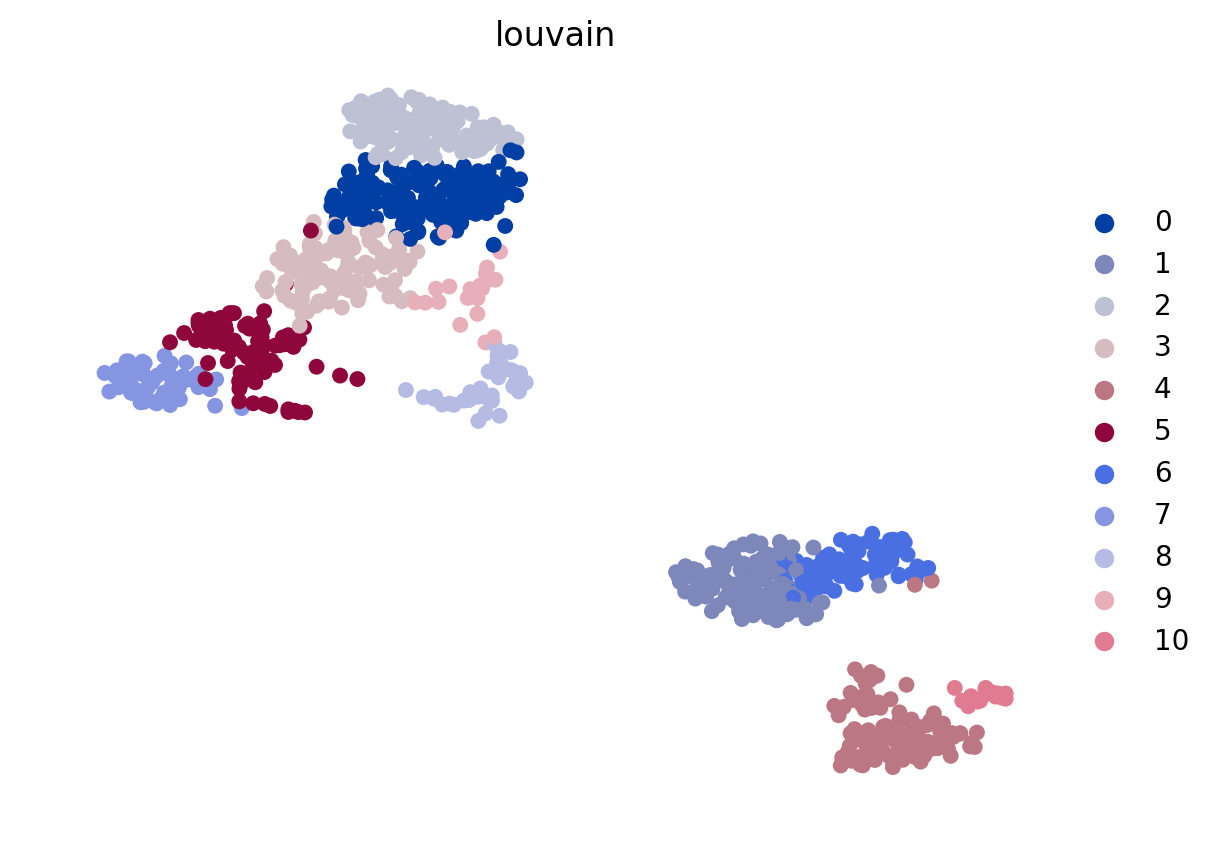

In [295]:
# compute simple manifold and first clustering
sc.pp.highly_variable_genes(adata_norm,n_top_genes=3000)
sc.pp.pca(adata_norm)
sc.pp.neighbors(adata_norm)
sc.tl.umap(adata_norm)
sc.tl.louvain(adata_norm,resolution=1.8)
sc.pl.umap(adata_norm,color=['louvain'])

In [51]:
# select only non-cycling beta cell clusters for downstream analyses
adata_beta_norm=adata_norm[np.isin(adata_norm.obs['louvain'],['0','2','3','5','7','9'])].copy()
# exclude delta cells by expression threshold
adata_beta_norm=adata_beta_norm[adata_beta_norm[:,'Sst'].X<4].copy()
adata_beta_norm=adata_beta_norm[adata_beta_norm[:,'Hhex'].X<4].copy()

# repeat gene filtering to remove lowly expressed genes in beta cells                              
sc.pp.filter_genes(adata_beta_norm,min_cells=15)

/Users/sophie/miniconda3/envs/scanpy_latest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


filtered out 7261 genes that are detectedin less than 15 cells


In [ ]:
# compute manifold

In [56]:
sc.pp.highly_variable_genes(adata_beta_norm,n_top_genes=2000)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


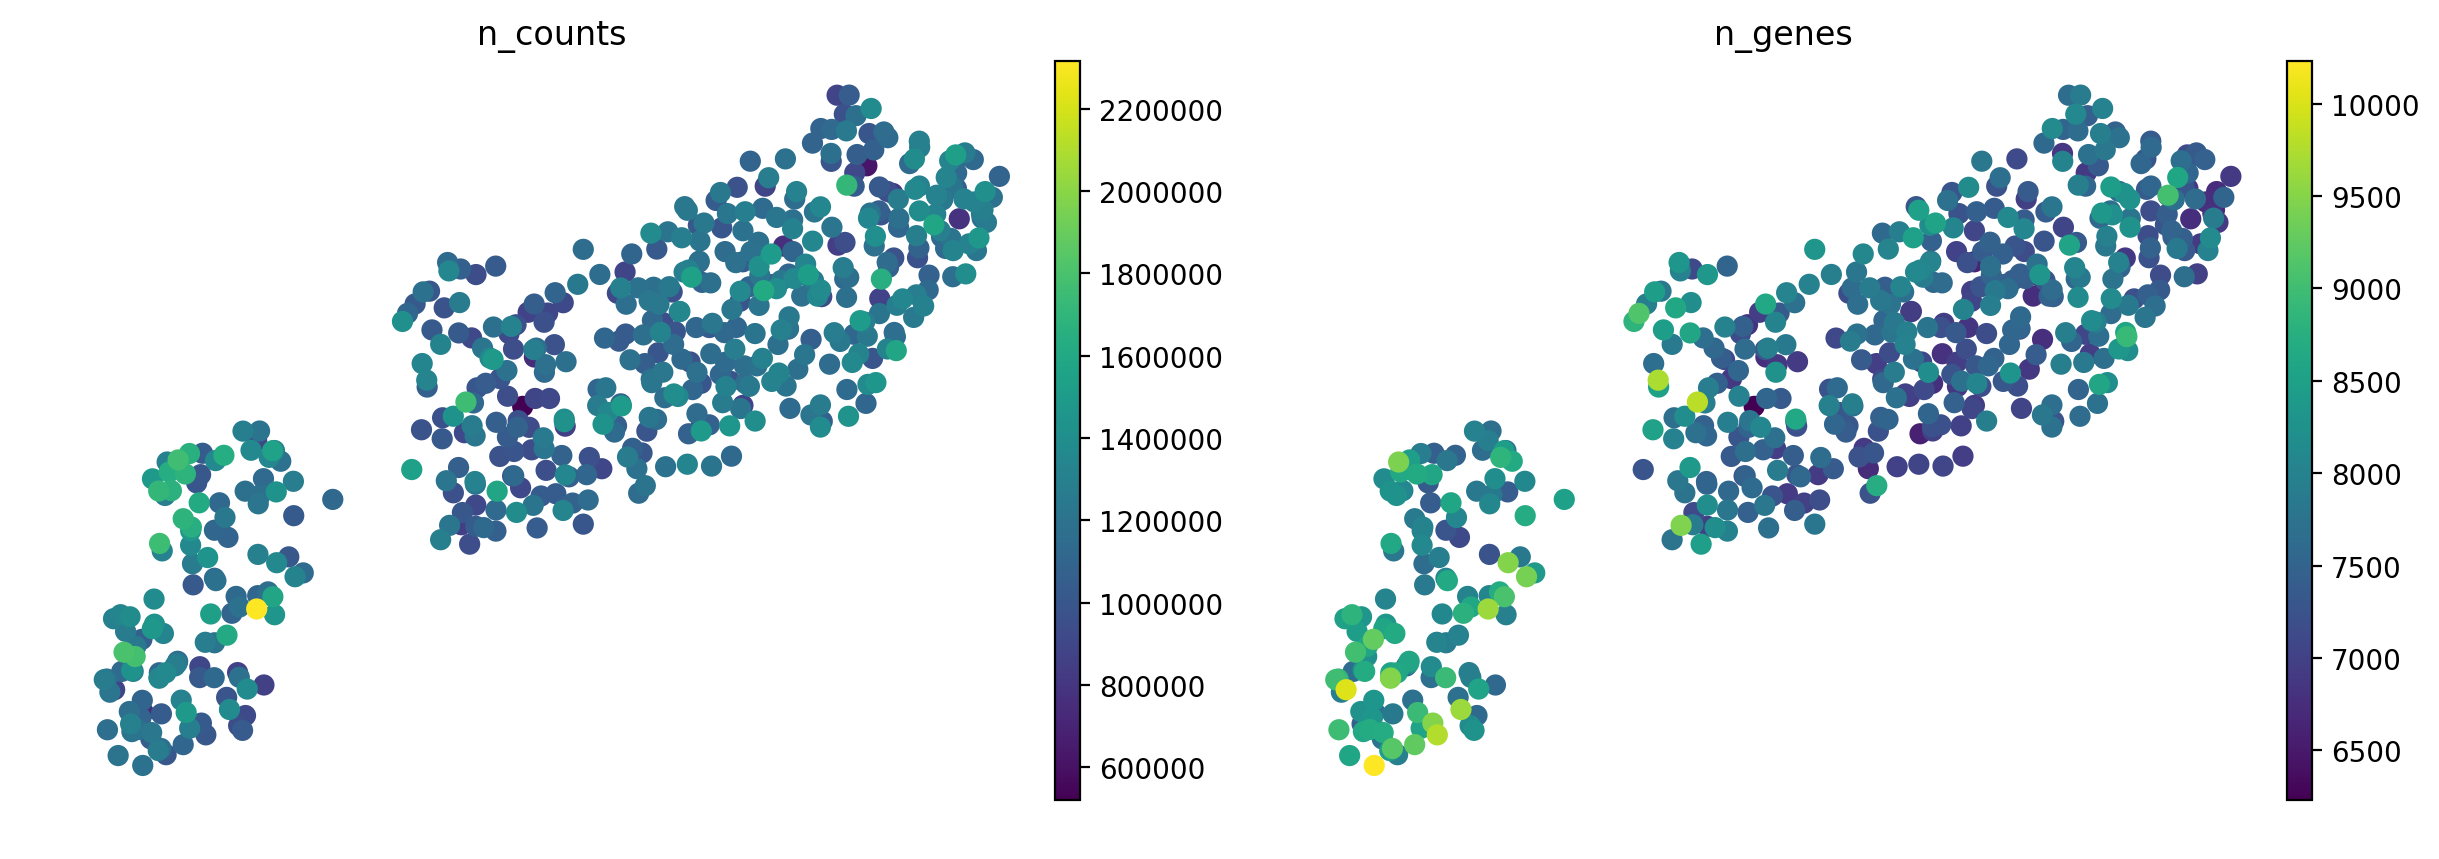

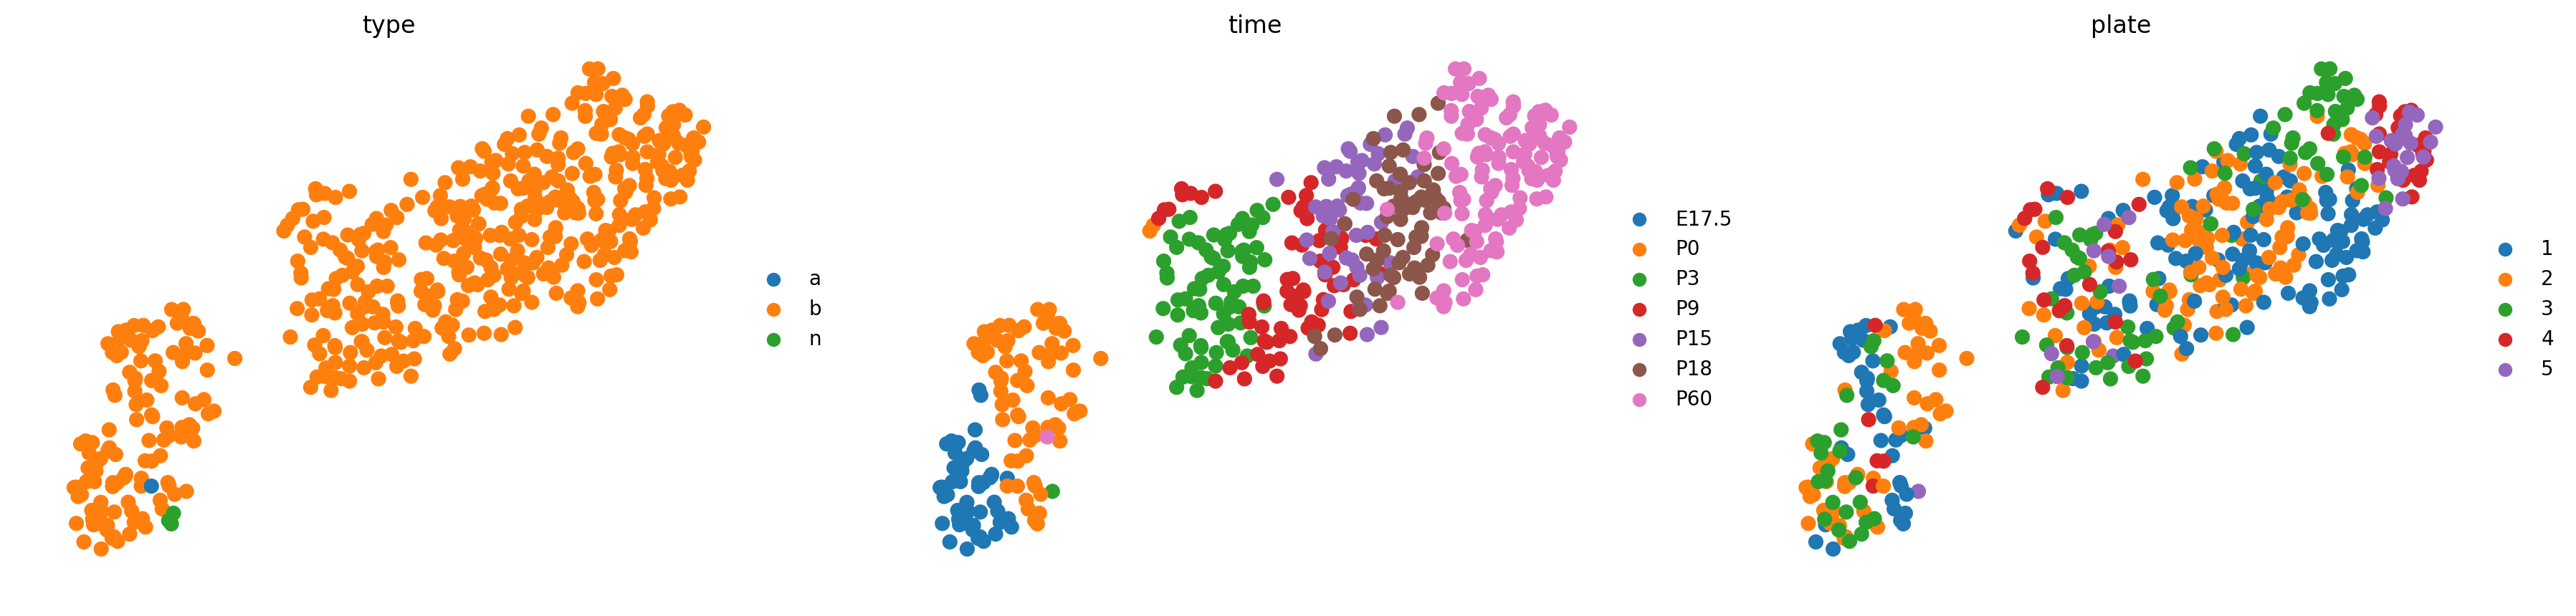

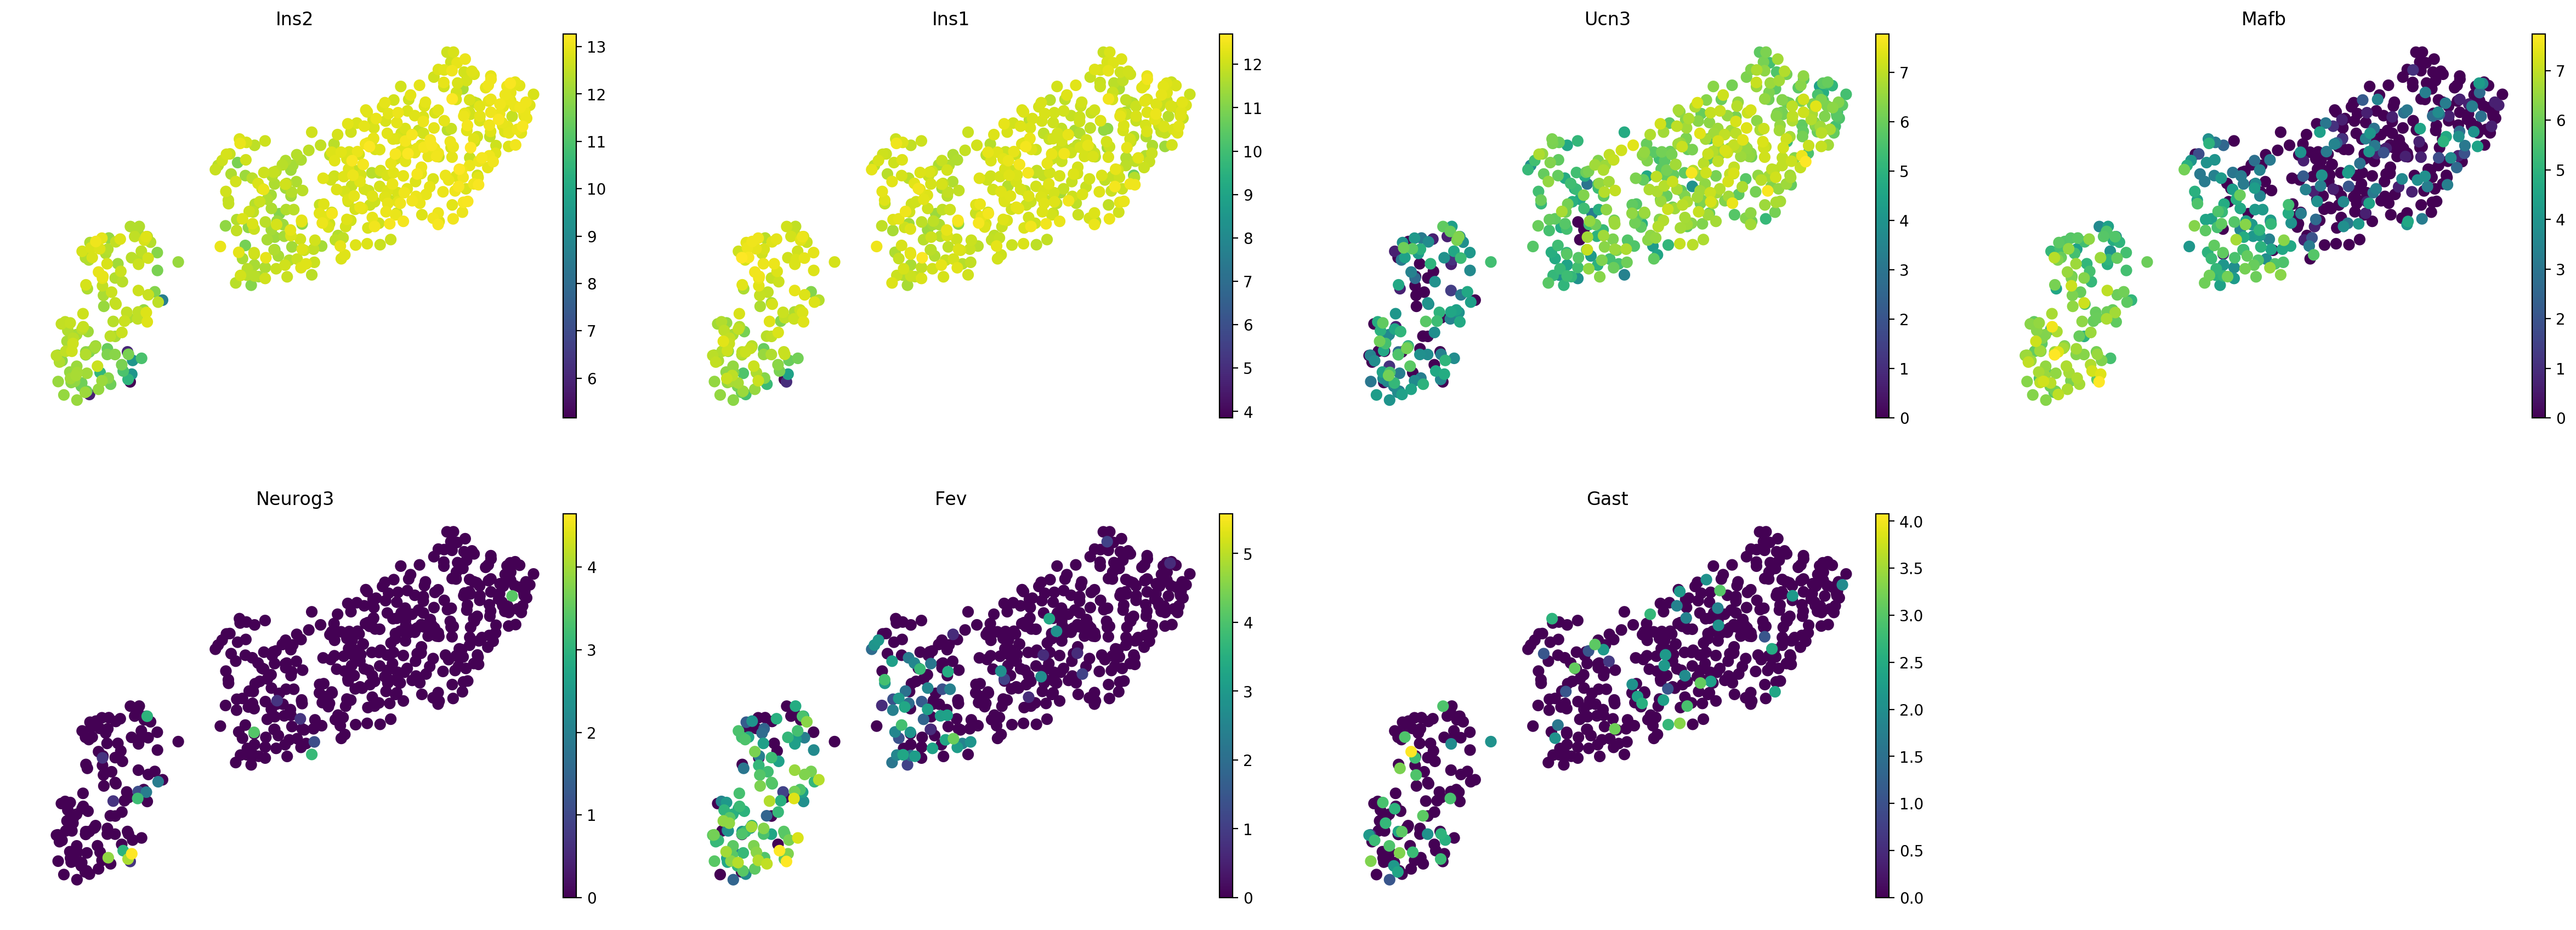

In [259]:
sc.pp.pca(adata_beta_norm)
sc.pp.neighbors(adata_beta_norm)
sc.tl.umap(adata_beta_norm)
sc.pl.umap(adata_beta_norm,color=['n_counts','n_genes'])
sc.pl.umap(adata_beta_norm,color=['type','time','plate'])
sc.pl.umap(adata_beta_norm,color=['Ins2','Ins1','Ucn3','Mafb','Neurog3','Fev','Gast'])

# Curate data of manuscript 

In [54]:
adata_stz_all=sc.read('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/write/endo_norm_log_paper.h5ad',cache=False)

adata_stz_all.uns['treatment_colors']=['#000000', '#999999', '#fffe66', '#73fcd5', '#0004fe', '#fd6565','#750002']
adata_stz_beta=adata_stz_all[np.isin(adata_stz_all.obs['groups_named_broad'],['beta'])]

In [57]:
adata_stz_beta.uns['treatment_colors']=['#000000', '#999999', '#fffe66', '#73fcd5', '#0004fe', '#fd6565','#750002']
adata_stz_beta.uns['groups_named_fine_colors']=['#a50f15', '#f46d43', '#fdae61']

In [55]:
sc.pp.filter_genes(adata_stz_beta,min_cells=15)

filtered out 3049 genes that are detectedin less than 15 cells


Trying to set attribute `.var` of view, making a copy.


In [ ]:
adata_stz_beta_red=adata_stz_beta_red[np.isin(adata_stz_beta_red.obs['treatment'],['Ctrl','Vehicle-STZ'])].copy()

# Data integration

In [ ]:
# feature selection: common genes in set of highly variable genes of reference data, remove highly expressed hormones of other endocrine cells

gene_union=[g for g in adata_stz_beta.var_names if g in adata_beta_norm.var_names[adata_beta_norm.var['highly_variable']] and g not in ['Gcg','Ppy','Pyy','Sst','Ttr']]

adata_stz_beta_red=adata_stz_beta_red[:,gene_union].copy()
adata_beta_norm_red=adata_beta_norm_red[:,gene_union].copy()

print(len(adata_beta_norm_red.var_names))
print(len(adata_stz_beta_red.var_names))


In [ ]:
# remove cycling cells
adata_stz_beta_red=adata_stz_beta[adata_stz_beta[:,'Mki67'].X<1].copy()
adata_beta_norm_red=adata_beta_norm[adata_beta_norm[:,'Mki67'].X<1].copy()

In [171]:
# randomly downsample beta 1 and beta-STZ subpopulation to 500 cells

x_samp=adata_stz_beta_red.obs_names[np.isin(adata_stz_beta_red.obs['groups_named_fine'],['Ins_1'])]
x_samp=np.random.choice(x_samp,500,replace=False)
x_obs=list(x_samp)+list(adata_stz_beta_red.obs_names[np.isin(adata_stz_beta_red.obs['groups_named_fine'],['Ins_2','Ins_dedifferentiated'])])
adata_stz_beta_red=adata_stz_beta_red[x_obs].copy()


x_samp=adata_stz_beta_red.obs_names[np.isin(adata_stz_beta_red.obs['groups_named_fine'],['Ins_dedifferentiated'])]
x_samp=np.random.choice(x_samp,500,replace=False)
x_obs=list(x_samp)+list(adata_stz_beta_red.obs_names[np.isin(adata_stz_beta_red.obs['groups_named_fine'],['Ins_2','Ins_1'])])
adata_stz_beta_red=adata_stz_beta_red[x_obs].copy()

print(adata_stz_beta_red.obs['groups_named_fine'].value_counts())
print(len(adata_stz_beta_red.obs_names))

/Users/sophie/miniconda3/envs/scanpy_latest/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


1654
1654
Ins_dedifferentiated    500
Ins_1                   500
Ins_2                   307
Name: groups_named_fine, dtype: int64
1307


In [297]:
adata_union

AnnData object with n_obs × n_vars = 1788 × 1654 
    obs: 'G2M_score', 'Ins-Gcg-Sst', 'S_score', 'comb_clust', 'comb_treat', 'doublet_score', 'dpt_pseudotime', 'groups', 'groups_named_beta_dpt', 'groups_named_broad', 'groups_named_broad_cond', 'groups_named_fine', 'louvain', 'mt_frac', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'phase', 'plate', 'proliferation', 'proliferation_man', 'sample', 'time', 'treatment', 'type'
    var: 'n_cells-stz', 'GeneLength-postnatal', 'n_cells-postnatal', 'highly_variable-postnatal', 'means-postnatal', 'dispersions-postnatal', 'dispersions_norm-postnatal'
    uns: 'comb_clust_colors', 'comb_clust_sizes', 'comb_treat_colors', 'comb_treat_sizes', 'diffmap_evals', 'groups_named_fine_colors', 'iroot', 'neighbors', 'paga', 'pca', 'time_colors', 'treatment_colors'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'

In [172]:
# scale data sets
sc.pp.scale(adata_beta_norm_red,zero_center=True)
sc.pp.scale(adata_stz_beta_red,zero_center=True)


In [ ]:
# cell annotation for embedded data
adata_stz_beta_red.obs['comb_treat']=adata_stz_beta_red.obs['treatment']
adata_beta_norm_red.obs['comb_treat']=adata_beta_norm_red.obs['time']
adata_stz_beta_red.obs['comb_clust']=adata_stz_beta_red.obs['groups_named_fine']
adata_beta_norm_red.obs['comb_clust']=adata_beta_norm_red.obs['time']

In [173]:
adata_union=adata_stz_beta_red.concatenate(adata_beta_norm_red,batch_key='sample',batch_categories=['stz','postnatal'],join='inner')

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)


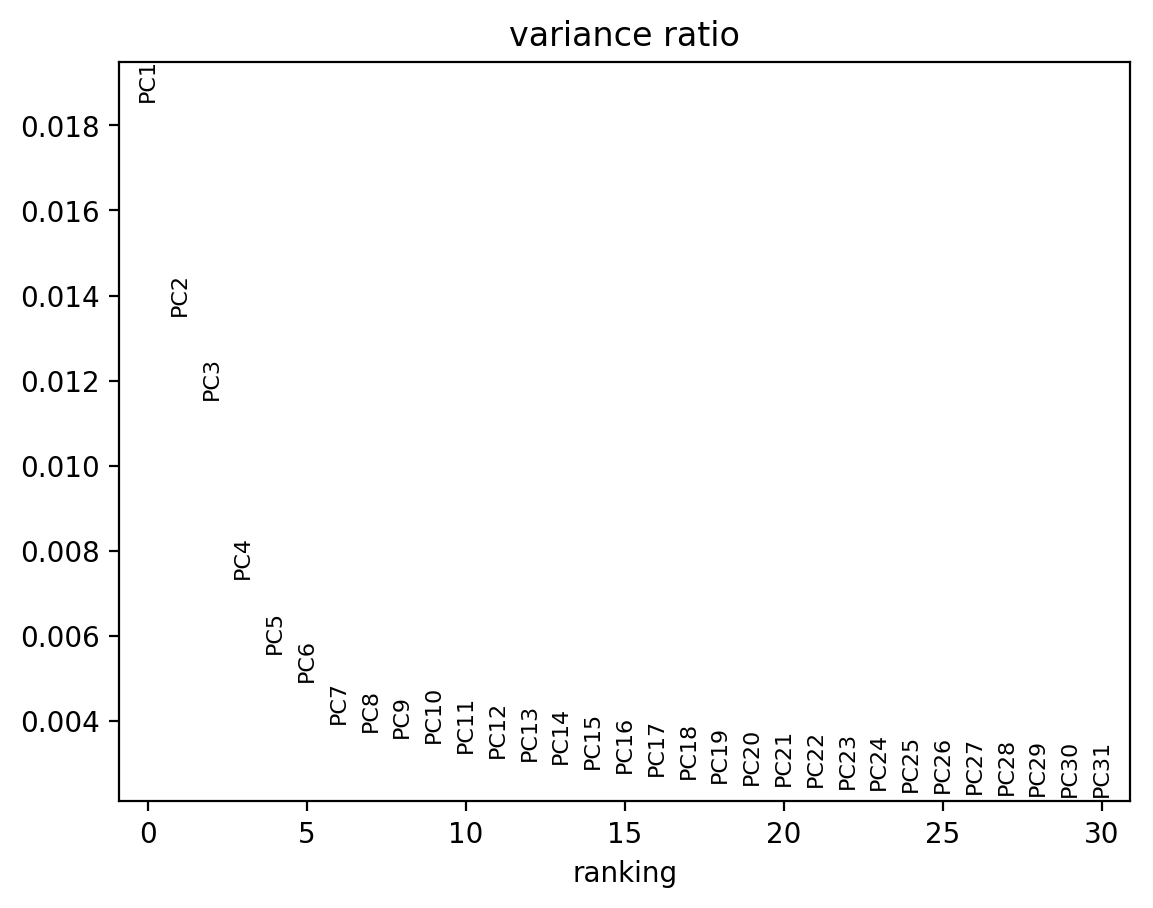

In [174]:
sc.pp.pca(adata_union,n_comps=50)
sc.pl.pca_variance_ratio(adata_union)

In [175]:
# select 10 PCs
sc.pp.pca(adata_union,n_comps=10)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 10
    finished (0:00:00)


In [199]:
# order cell annotation variables

adata_union.obs['treatment']=adata_union.obs['treatment'].cat.reorder_categories(['Ctrl','Vehicle-STZ','nan'])
adata_union.obs['comb_clust']=adata_union.obs['comb_clust'].cat.reorder_categories(['Ins_1', 'Ins_2', 'Ins_dedifferentiated',
                                                                                    'E17.5', 'P0', 'P3', 'P9','P15', 'P18', 'P60'])
adata_union.obs['comb_treat']=adata_union.obs['comb_treat'].cat.reorder_categories(['Ctrl', 'Vehicle-STZ',
                                                                                    'E17.5','P0', 'P3', 'P9', 'P15', 'P18', 'P60', ])

# associate colors for plotting
adata_union.uns['treatment_colors']=adata_stz_beta.uns['treatment_colors'][0:1]+['#d9d9d9']
adata_union.uns['groups_named_fine_colors']=adata_stz_beta.uns['groups_named_fine_colors']+['#d9d9d9']
adata_union.uns['time_colors']=['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529','#d9d9d9']
adata_union.uns['comb_clust_colors']=adata_union.uns['groups_named_fine_colors'][0:3]+adata_union.uns['time_colors']
adata_union.uns['comb_treat_colors']=adata_union.uns['treatment_colors'][0:7]+adata_union.uns['time_colors']

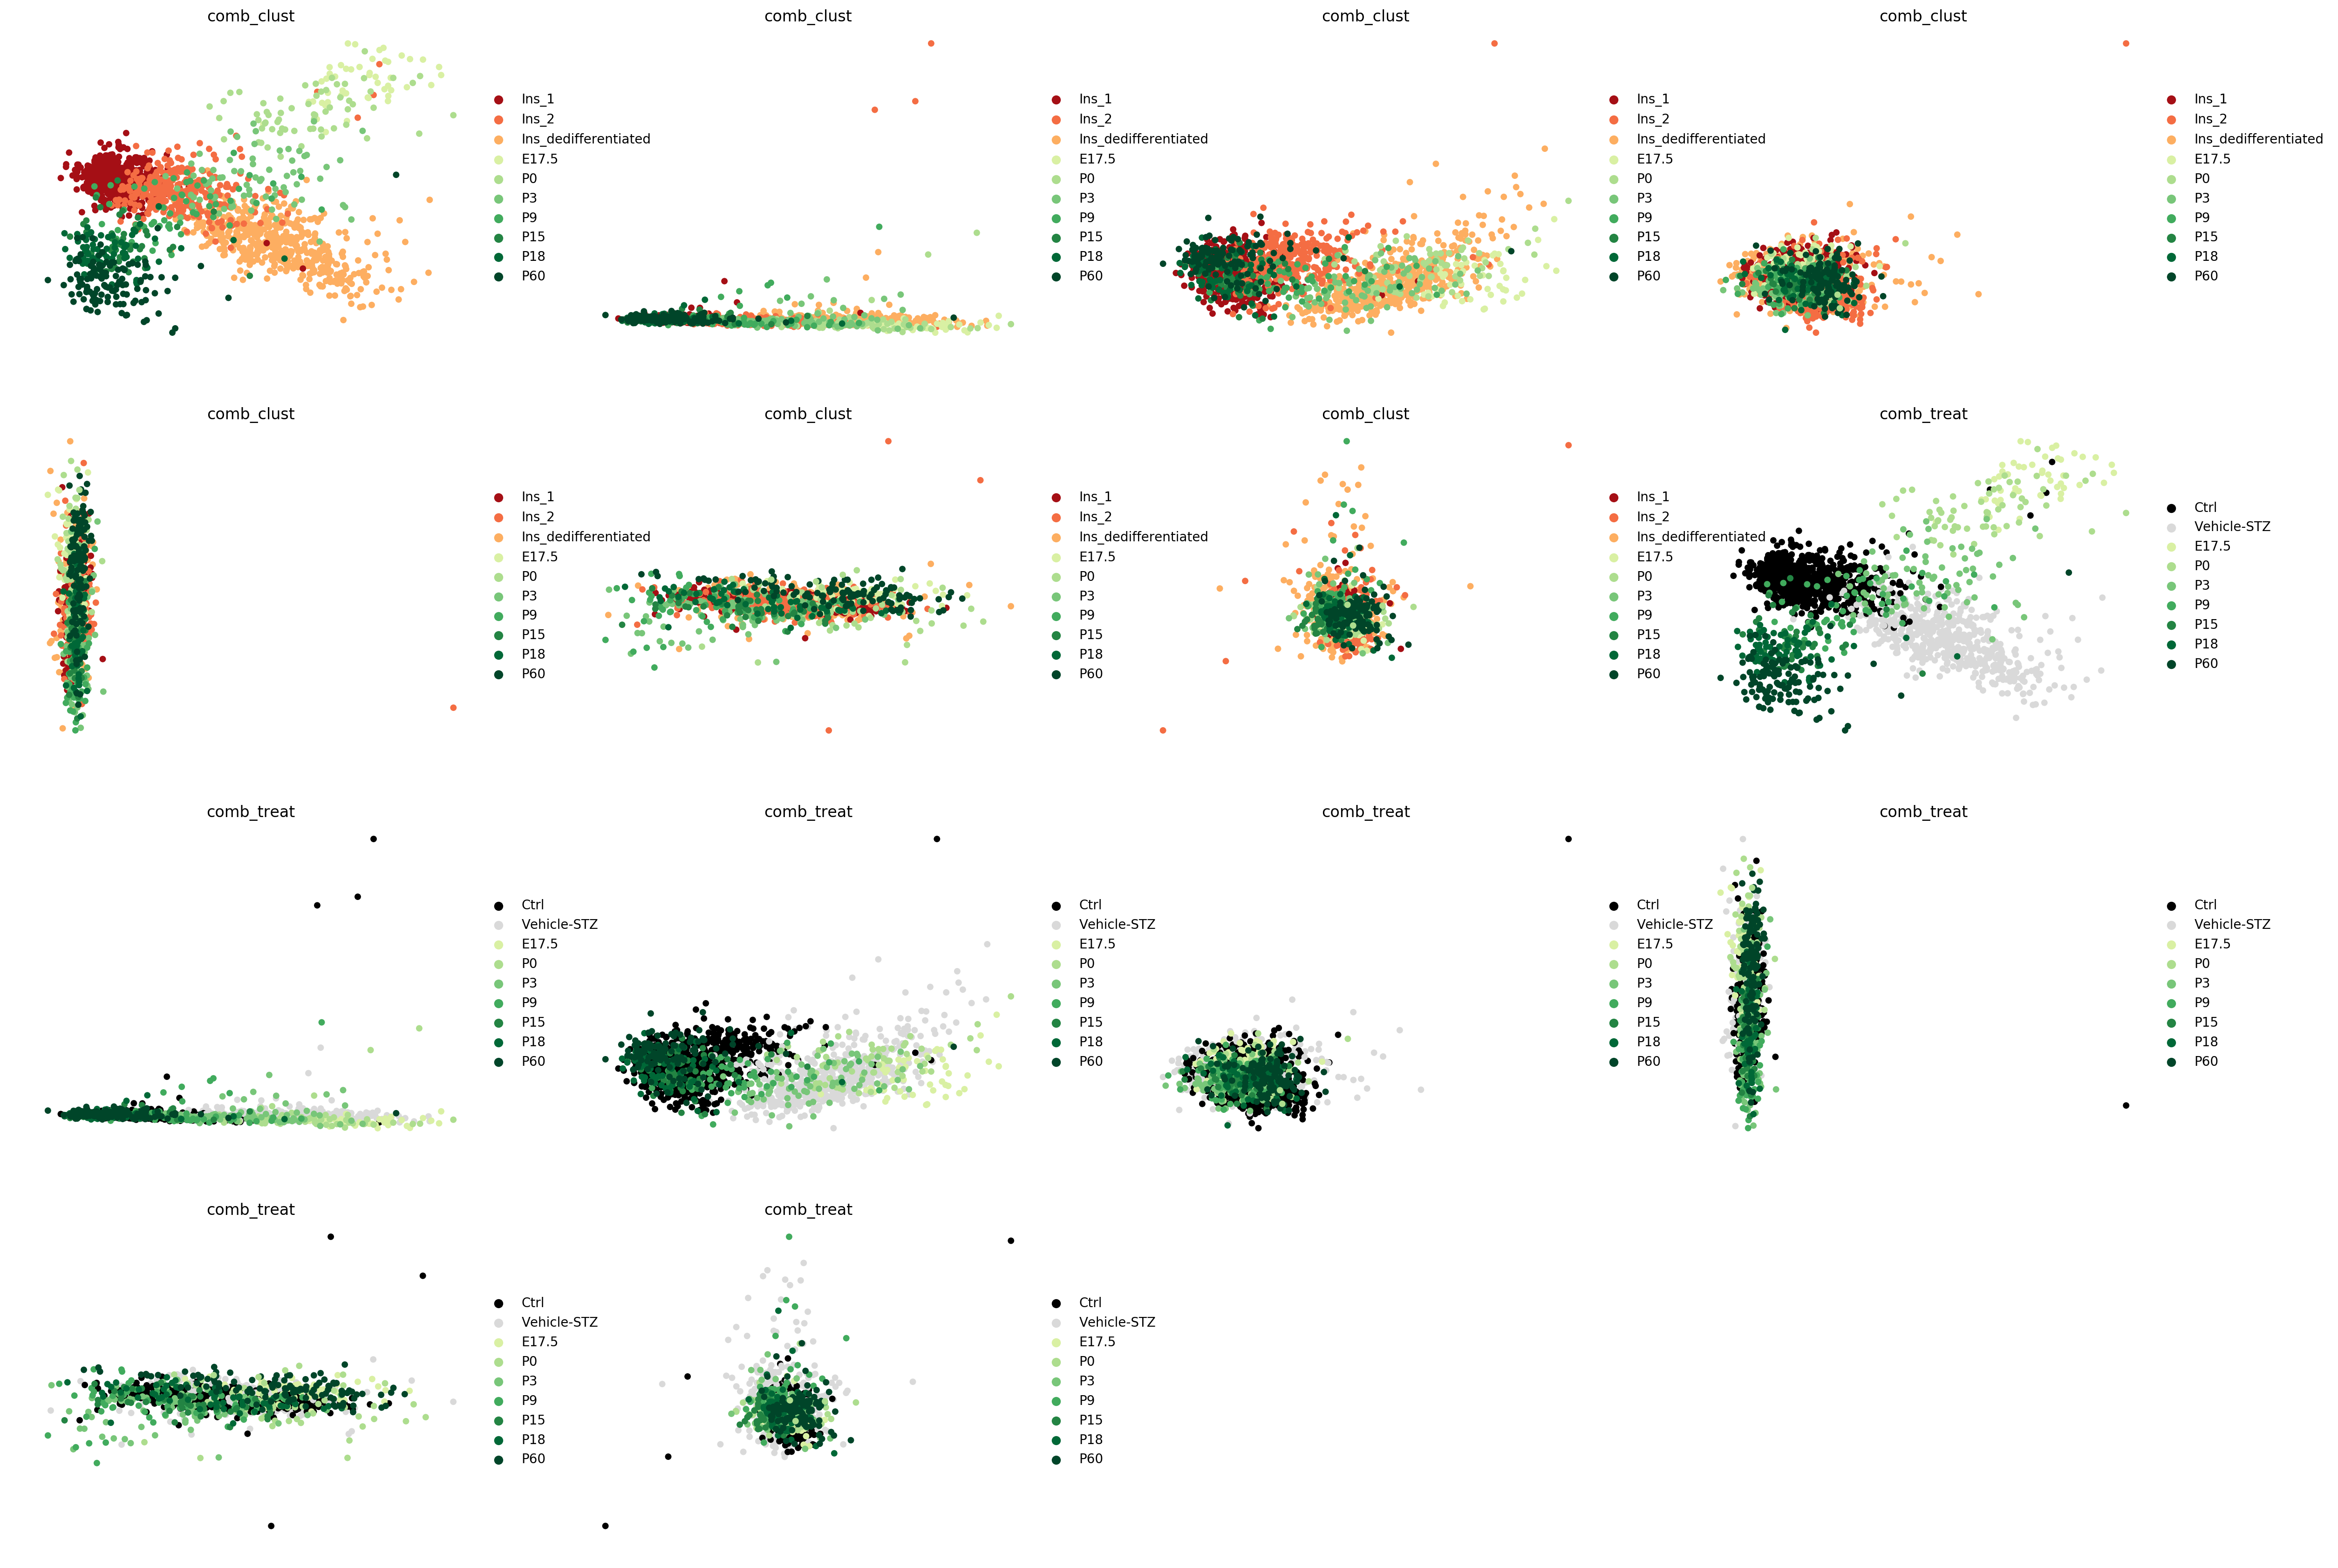

In [177]:
sc.pl.pca(adata_union,color=['comb_clust','comb_treat'],size=100,components=['1,2','1,3','1,4','4,5','6,7','7,8','9,10'])

In [179]:
# compute common kNN with Bbknn
sce.pp.bbknn(adata_union,batch_key='sample',neighbors_within_batch=5)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)


# PAGA

In [321]:
# PAGA cluster positions for plotting
pos=np.array([[ 0.5, -0],
       [-2, -0],
       [-4.5, -0],
       [-5, -0.5],
       [-4, -0.5],
       [-3, -0.5],
       [-2, -0.5],
       [-1, -0.5],
       [0, -0.5],
       [1, -0.5]])

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


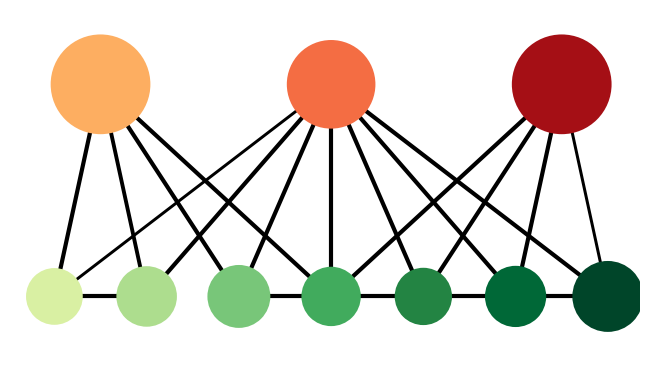

In [323]:
sc.settings.figdir='/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/'
sc.tl.paga(adata_union,groups='comb_clust')
sc.pl.paga(adata_union,edge_width_scale=0.2,threshold=0.7,frameon=False,pos=pos,save='_union_groups.pdf',labels=['','','','','','','','','',''],node_size_scale=3)

# Trajectory inference

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9680856  0.94155204 0.93566775 0.92454016 0.9206638
     0.90221494 0.90162826 0.8951339  0.8812338  0.87472594 0.87350935
     0.8678392  0.86114293 0.8594779 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=5
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


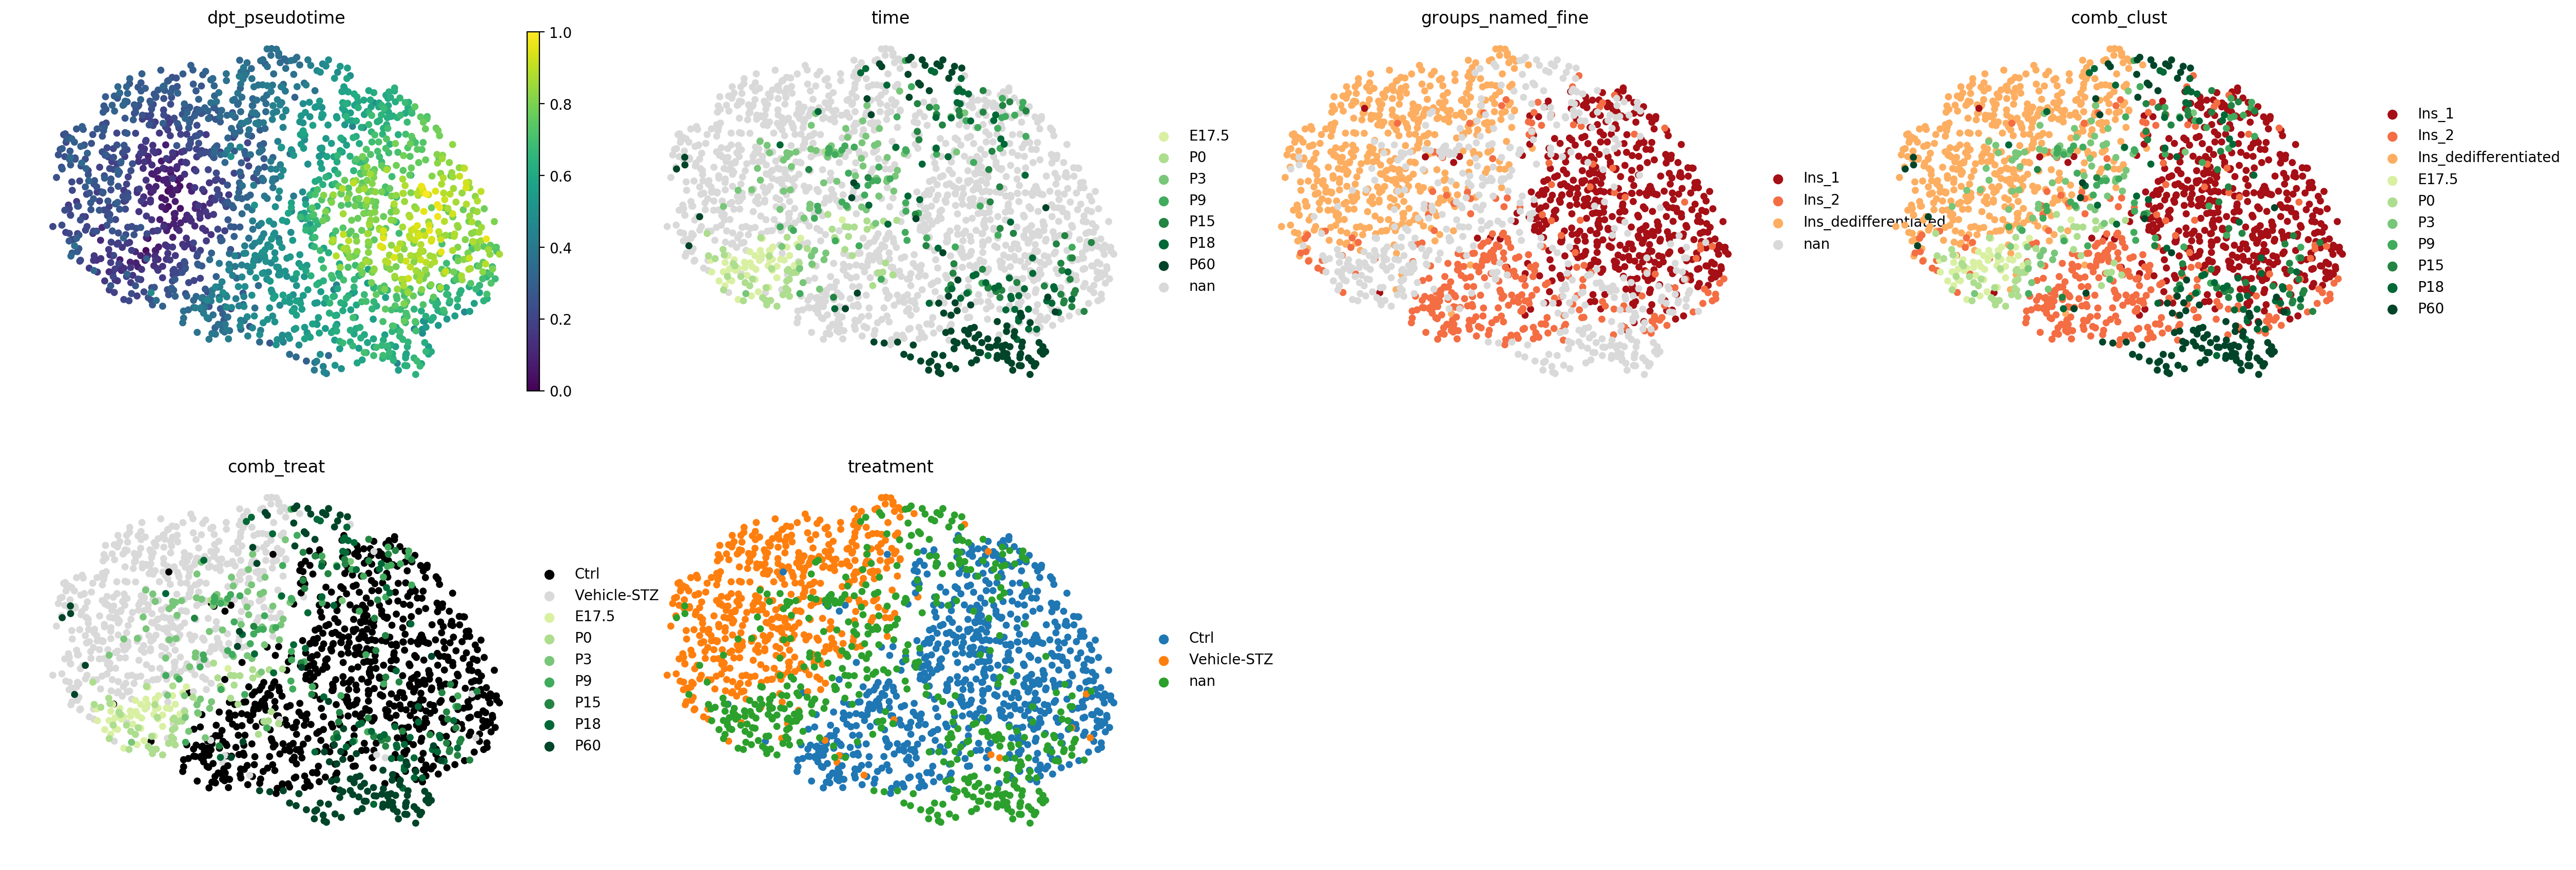

In [185]:
# trajectory inference
adata_union.uns['iroot']=np.flatnonzero(adata_union.obs['time'] == 'E17.5')[0]
sc.tl.dpt(adata_union,n_dcs=5)
sc.tl.umap(adata_union)
sc.pl.umap(adata_union,color=['dpt_pseudotime','time','groups_named_fine','comb_clust','comb_treat','treatment'],size=100)

## Plot cell density along trajectory

E17.5
P0
P3
P9
P15
P18
P60


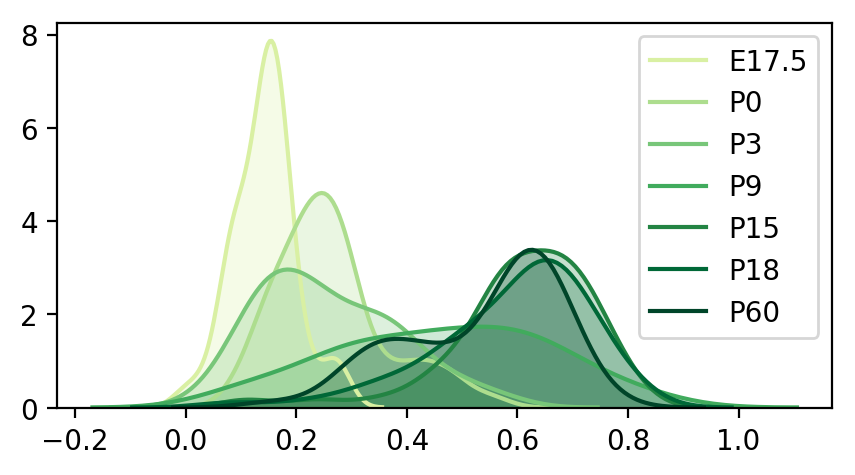

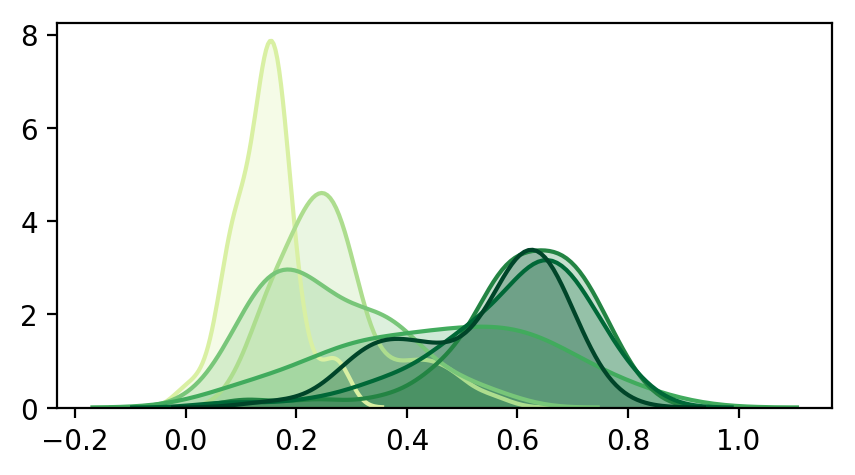

In [188]:
df=adata_union.obs
rcParams['figure.figsize'] = (5, 2.5)
fig,ax=pl.subplots()

group='time'
cats=adata_union.obs[group].cat.categories[0:7]
cols=adata_union.uns[group+'_colors'][0:7]
for i,treat in enumerate(cats):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,color=cols[i])
    pl.legend(labels=cats)
pl.show()

fig,ax=pl.subplots()
for i,treat in enumerate(cats):
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,legend=False,color=cols[i])
pl.show()
pl.rcParams.update(pl.rcParamsDefault)

Ins_1
Ins_2
Ins_dedifferentiated
E17.5
P0
P3
P9
P15
P18
P60


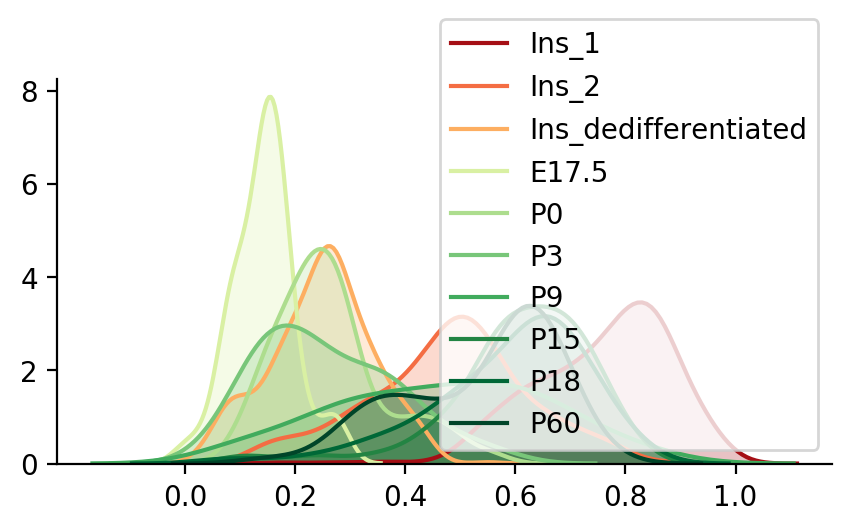

Ins_1
Ins_2
Ins_dedifferentiated
E17.5
P0
P3
P9
P15
P18
P60


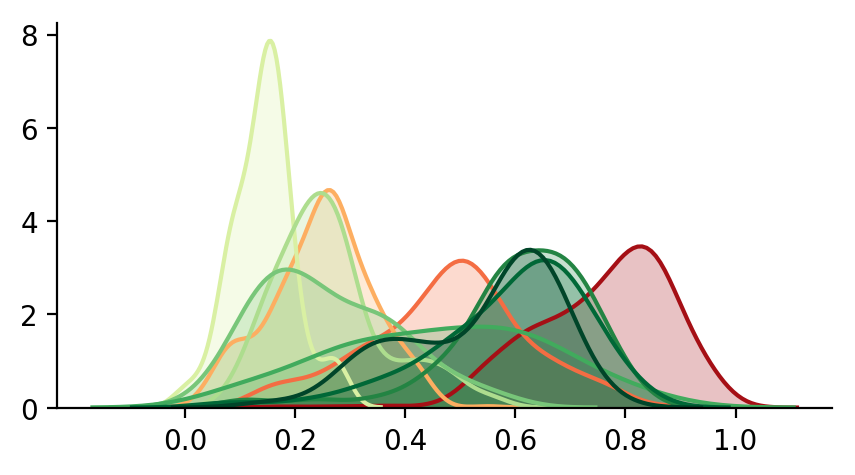

E17.5
P0
P3
P9
P15
P18
P60


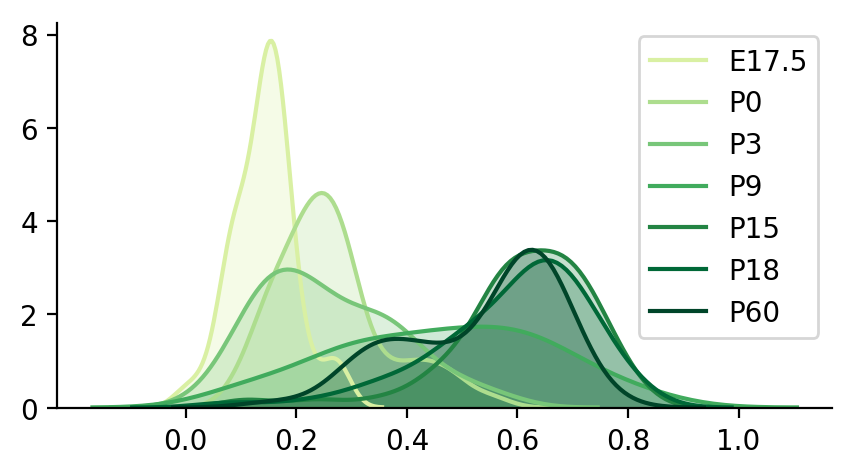

E17.5
P0
P3
P9
P15
P18
P60


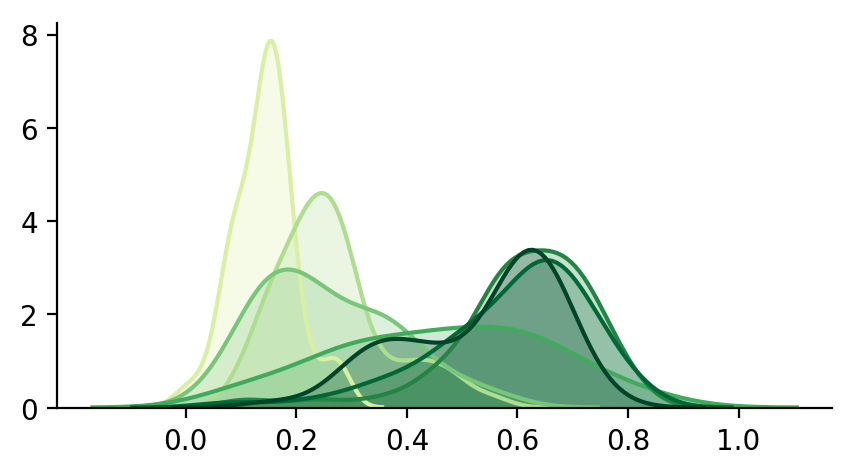

Ins_1
Ins_2
Ins_dedifferentiated


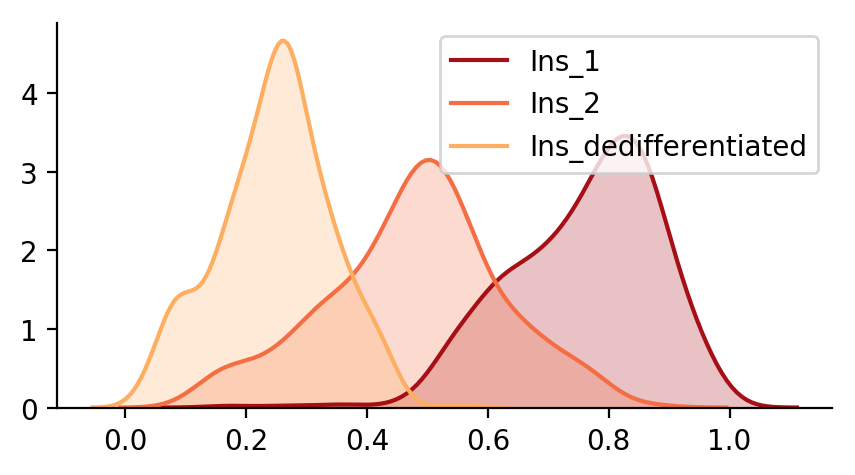

Ins_1
Ins_2
Ins_dedifferentiated


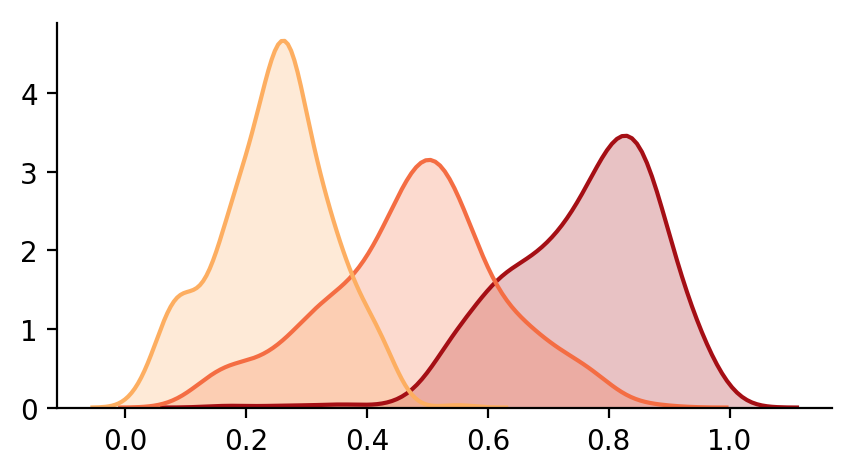

Ctrl
Vehicle-STZ


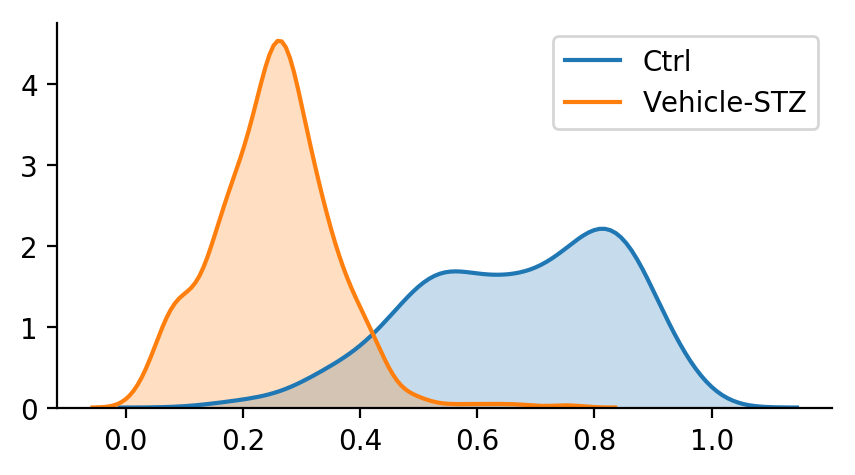

Ctrl
Vehicle-STZ


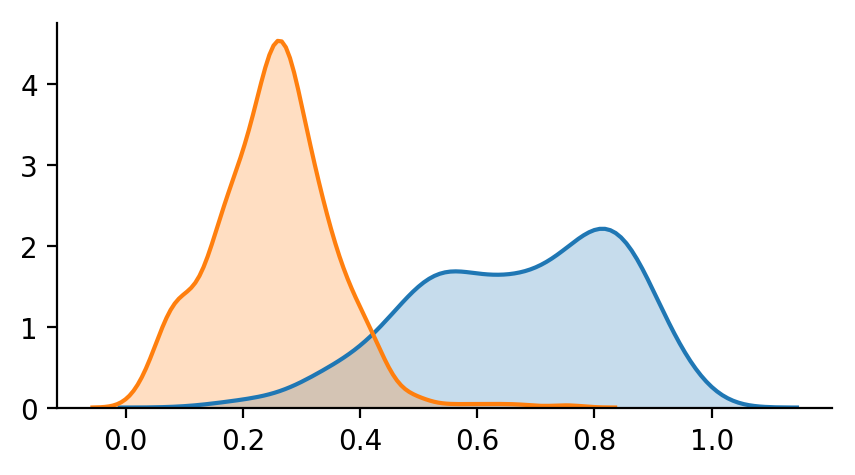

In [189]:
rcParams['figure.figsize'] = (5, 2.5)
fig,ax=pl.subplots()
group='comb_clust'
cols=adata_union.uns[group+'_colors']
for i,treat in enumerate(adata_union.obs[group].cat.categories):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,color=cols[i])
    pl.legend(labels=adata_union.obs[group].cat.categories)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.show()

fig,ax=pl.subplots()
for i,treat in enumerate(adata_union.obs[group].cat.categories):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,legend=False,color=cols[i])
    #pl.legend(labels=adata_union.obs[group].cat.categories)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.savefig('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/trajectory_all.pdf')
pl.show()


fig,ax=pl.subplots()
group='time'
cats=adata_union.obs[group].cat.categories[0:7]
cols=adata_union.uns[group+'_colors'][0:7]
for i,treat in enumerate(cats):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,color=cols[i])
    pl.legend(labels=cats)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.show()

fig,ax=pl.subplots()
for i,treat in enumerate(cats):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,legend=False,color=cols[i])
    #pl.legend(labels=adata_union.obs[group].cat.categories)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.savefig('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/trajectory_qiu.pdf')

pl.show()


fig,ax=pl.subplots()
group='groups_named_fine'
cols=adata_union.uns[group+'_colors'][0:3]
cats=adata_union.obs[group].cat.categories[0:3]
for i,treat in enumerate(cats):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,color=cols[i])
    pl.legend(labels=cats)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.show()

fig,ax=pl.subplots()
for i,treat in enumerate(cats):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,legend=False,color=cols[i])
    #pl.legend(labels=adata_union.obs[group].cat.categories)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.savefig('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/trajectory_stz.pdf')

pl.show()

fig,ax=pl.subplots()
group='treatment'
cols=adata_union.uns[group+'_colors'][0:2]
cats=adata_union.obs[group].cat.categories[0:2]
for i,treat in enumerate(cats):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,color=cols[i])
    pl.legend(labels=cats)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.show()

fig,ax=pl.subplots()
for i,treat in enumerate(cats):
    print(treat)
    df_sub=df[np.isin(df[group],treat)]
    sns.kdeplot(df_sub['dpt_pseudotime'],ax=ax,shade=True,legend=False,color=cols[i])
    #pl.legend(labels=adata_union.obs[group].cat.categories)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
pl.xticks([0,0.2,0.4,0.6,0.8,1.0])
pl.show()

pl.rcParams.update(pl.rcParamsDefault)





In [198]:
sc.write('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/write/adata_union_revision_norm_paper.h5ad',adata_union)

In [208]:
adata_union=sc.read('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/write/adata_union_revision_norm_paper.h5ad')

## Plot gene expression along trajectory

In [209]:
genes=['Ucn3','Mafb','Aldh1a3','Aqp4']
df=pd.DataFrame(adata_union[:,genes].copy().X,columns=genes)
df['pseudotime']=adata_union.obs['dpt_pseudotime'].values
df['comb_clust']=adata_union.obs['comb_clust'].values
df=df.sort_values(by='pseudotime',ascending=True)

In [ ]:
genes=['Ucn3','Rbp4']
rcParams['figure.figsize'] = (4, 2)

rcParams['figure.figsize'] = (4, 2)
csfont = {'fontname':'Arial'}

for gene in genes:
    #x_stats_1=stats.binned_statistic(df['pseudotime'].values, df[gene].values, 'mean', bins=10,range=(0,0.75))
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)

    #ax = sns.lineplot(y=x_stats_1.statistic, x=x_stats_1.bin_edges[0:len(x_stats_1.statistic)],color='red')
    ax= sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color='blue')
    sns.scatterplot(x=df['pseudotime'],y=df[gene],ax=ax,s=3,hue=df['comb_clust'],edgecolor='',palette=adata_union.uns['comb_clust_colors'][0:10],rasterized=True)
    ax.get_legend().remove()
    
    ax.xaxis.set_tick_params(bottom='on', top='off')
    ax.yaxis.set_tick_params(left='on', right='off')    

        #ax.set_xticks([])
        #ax.get_yaxis().set_ticks([])
    ax.set_xlabel('cell-to-cell distance',**csfont)
    ax.set_ylabel('scaled expression',**csfont)
    ax.set_title(gene,size=14,**csfont)
    ax.xaxis.set_tick_params(bottom='on', top='off')
    ax.yaxis.set_tick_params(left='on', right='off')    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    
    
    pl.savefig('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/trajectory_lineplot_'+gene+'.pdf',format='pdf',dpi=300)
    pl.show()

In [ ]:
genes=['Ucn3','Rbp4']
ix=np.isin(adata_union.obs['sample'],['postnatal'])

df=pd.DataFrame(adata_union[:,genes].copy().X,columns=genes)[ix]
df['pseudotime']=adata_union.obs['dpt_pseudotime'].values[ix]
df['comb_clust']=adata_union.obs['comb_clust'].values[ix]

df=df.sort_values(by='pseudotime',ascending=True)

rcParams['figure.figsize'] = (4, 2)
csfont = {'fontname':'Arial'}

for gene in genes:
    #x_stats_1=stats.binned_statistic(df['pseudotime'].values, df[gene].values, 'mean', bins=10,range=(0,0.75))
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)

    #ax = sns.lineplot(y=x_stats_1.statistic, x=x_stats_1.bin_edges[0:len(x_stats_1.statistic)],color='red')
    ax= sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color='blue')
    sns.scatterplot(x=df['pseudotime'],y=df[gene],ax=ax,s=3,hue=df['comb_clust'],edgecolor='',palette=adata_union.uns['comb_clust_colors'][0:10],rasterized=True)
    ax.get_legend().remove()
    
    ax.xaxis.set_tick_params(bottom='on', top='off')
    ax.yaxis.set_tick_params(left='on', right='off')    

        #ax.set_xticks([])
        #ax.get_yaxis().set_ticks([])
    ax.set_xlabel('cell-to-cell distance',**csfont)
    ax.set_ylabel('scaled expression',**csfont)
    ax.set_title(gene,size=14,**csfont)
    ax.xaxis.set_tick_params(bottom='on', top='off')
    ax.yaxis.set_tick_params(left='on', right='off')    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    
    
    pl.savefig('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/trajectory_lineplot_'+gene+'_pn.pdf',format='pdf',dpi=300)
    pl.show()

In [ ]:
genes=['Ucn3','Rbp4']
ix=np.isin(adata_union.obs['sample'],['stz'])

df=pd.DataFrame(adata_union[:,genes].copy().X,columns=genes)[ix]
df['pseudotime']=adata_union.obs['dpt_pseudotime'].values[ix]
df['comb_clust']=adata_union.obs['comb_clust'].values[ix]

df=df.sort_values(by='pseudotime',ascending=True)

rcParams['figure.figsize'] = (4, 2)
csfont = {'fontname':'Arial'}

for gene in genes:
    #x_stats_1=stats.binned_statistic(df['pseudotime'].values, df[gene].values, 'mean', bins=10,range=(0,0.75))
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=3)
    f = np.poly1d(fit)

    #ax = sns.lineplot(y=x_stats_1.statistic, x=x_stats_1.bin_edges[0:len(x_stats_1.statistic)],color='red')
    ax= sns.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color='blue')
    sns.scatterplot(x=df['pseudotime'],y=df[gene],ax=ax,s=3,hue=df['comb_clust'],edgecolor='',palette=adata_union.uns['comb_clust_colors'][0:10],rasterized=True)
    ax.get_legend().remove()
    
    ax.xaxis.set_tick_params(bottom='on', top='off')
    ax.yaxis.set_tick_params(left='on', right='off')    

        #ax.set_xticks([])
        #ax.get_yaxis().set_ticks([])
    ax.set_xlabel('cell-to-cell distance',**csfont)
    ax.set_ylabel('scaled expression',**csfont)
    ax.set_title(gene,size=14,**csfont)
    ax.xaxis.set_tick_params(bottom='on', top='off')
    ax.yaxis.set_tick_params(left='on', right='off')    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    
    
    pl.savefig('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/trajectory_lineplot_'+gene+'_stz.pdf',format='pdf',dpi=300)
    pl.show()

# Maturity and embryonic/immaturity cell scores

In [260]:
# clustering
sc.tl.louvain(adata_beta_norm)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


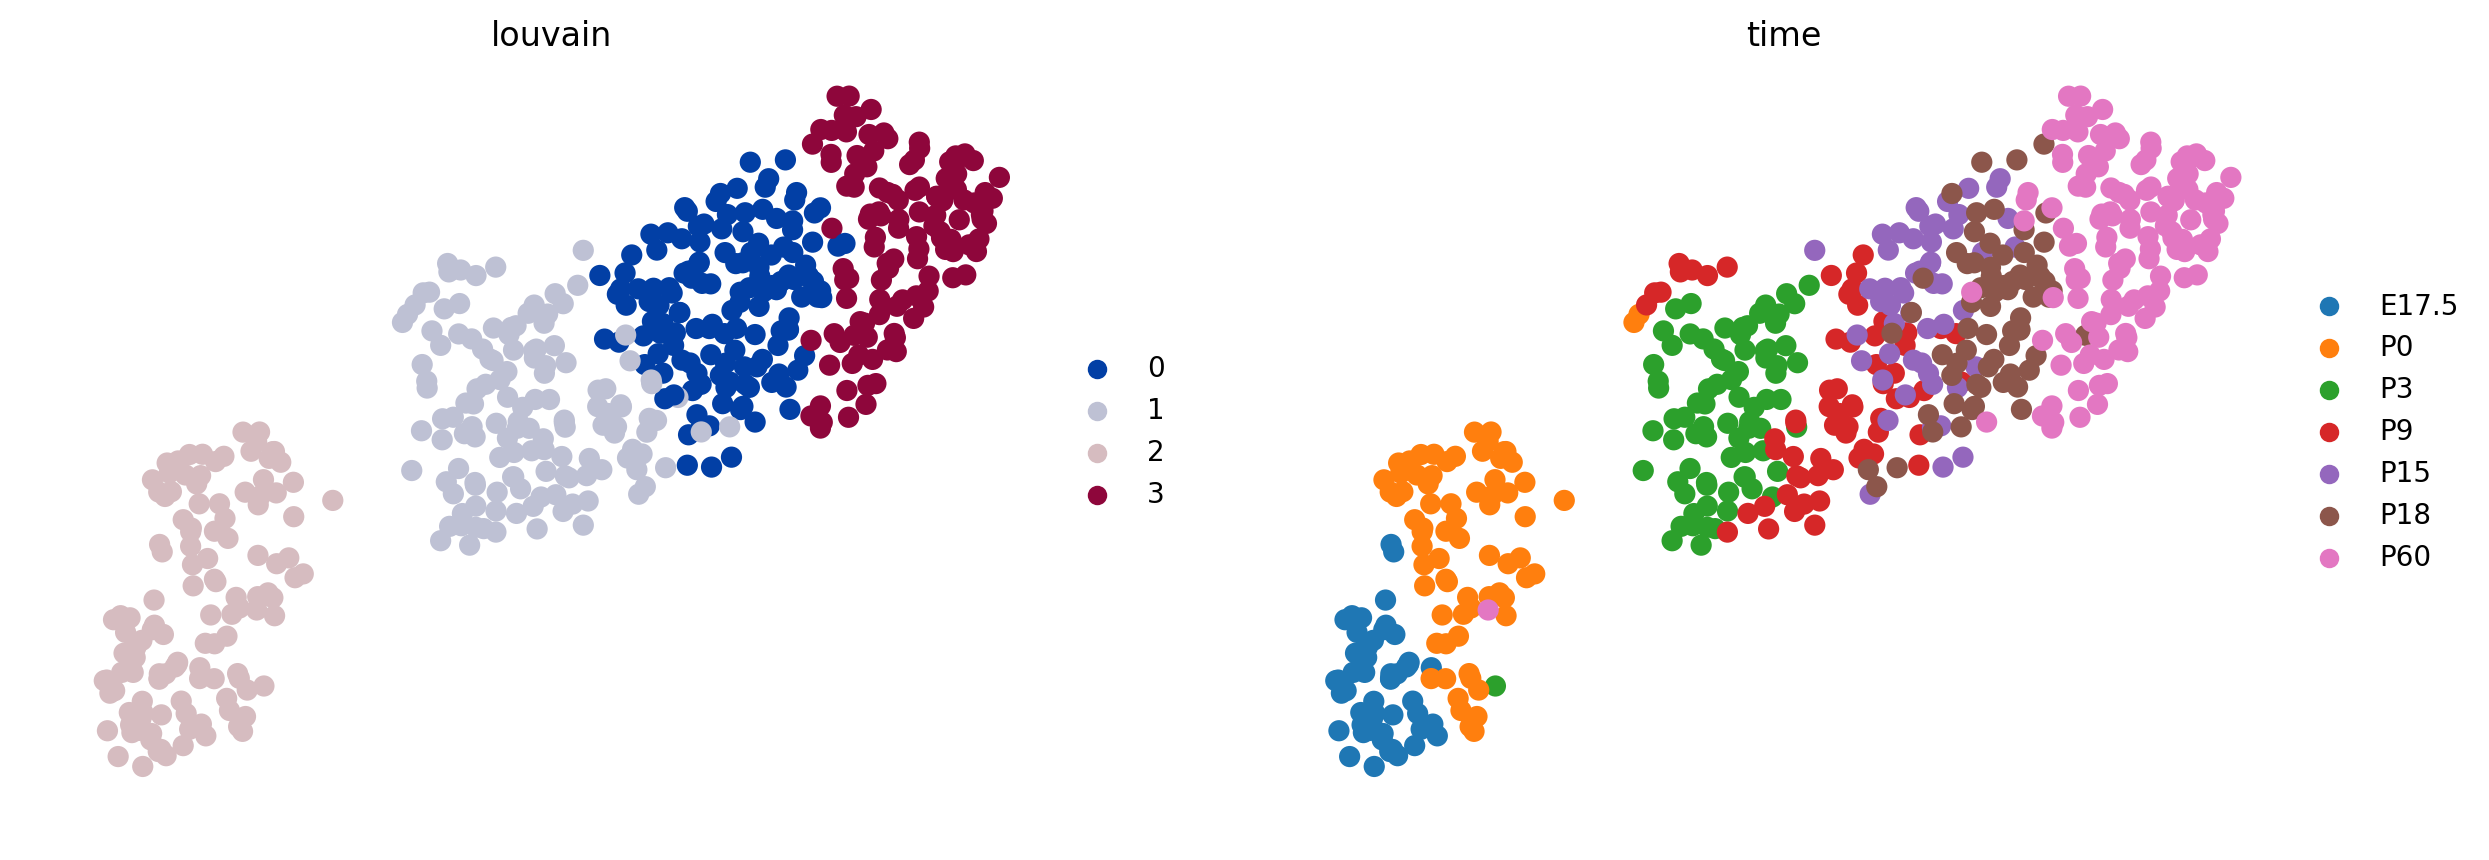

In [261]:
sc.pl.umap(adata_beta_norm,color=['louvain','time'])

## Extract gene sets (differential expression testing)

ranking genes
    finished: added to `.uns['rank_genes_2_vs_3']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


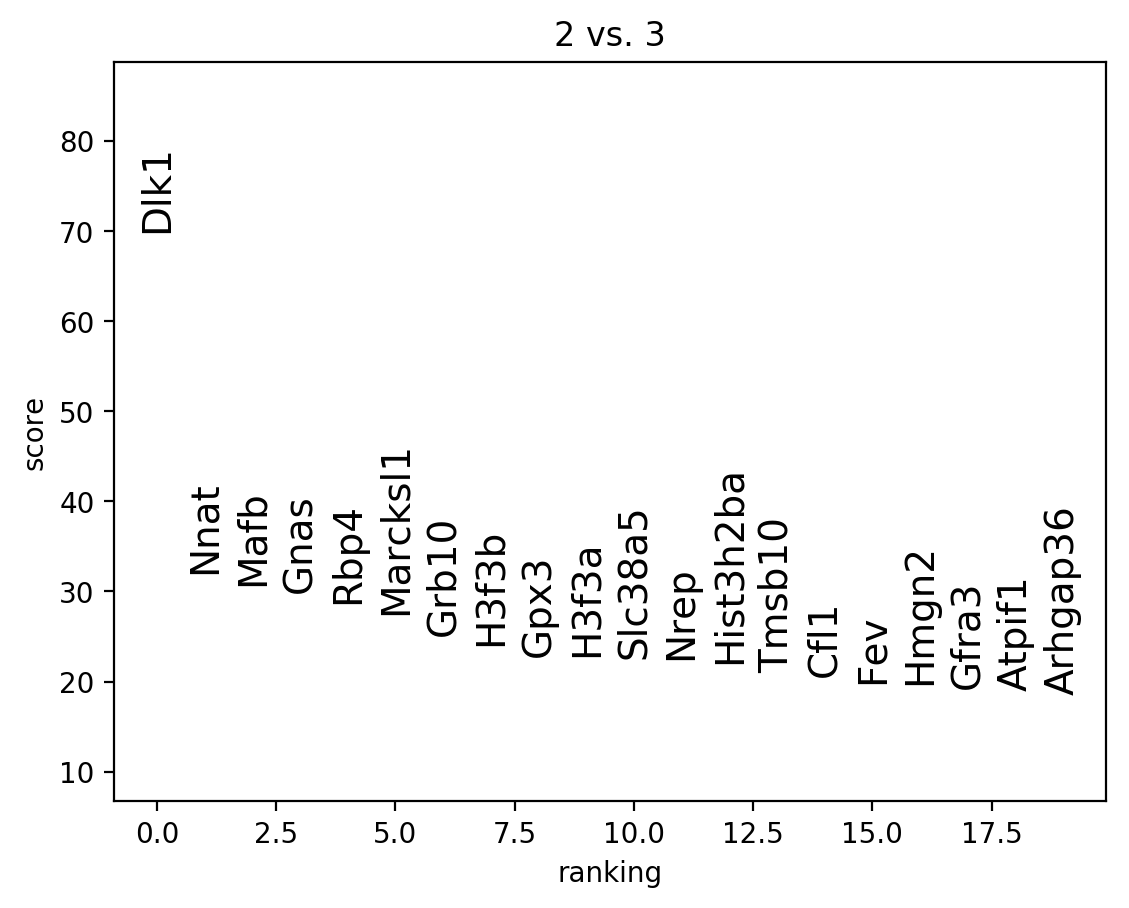

ranking genes
    finished: added to `.uns['rank_genes_3_vs_2']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


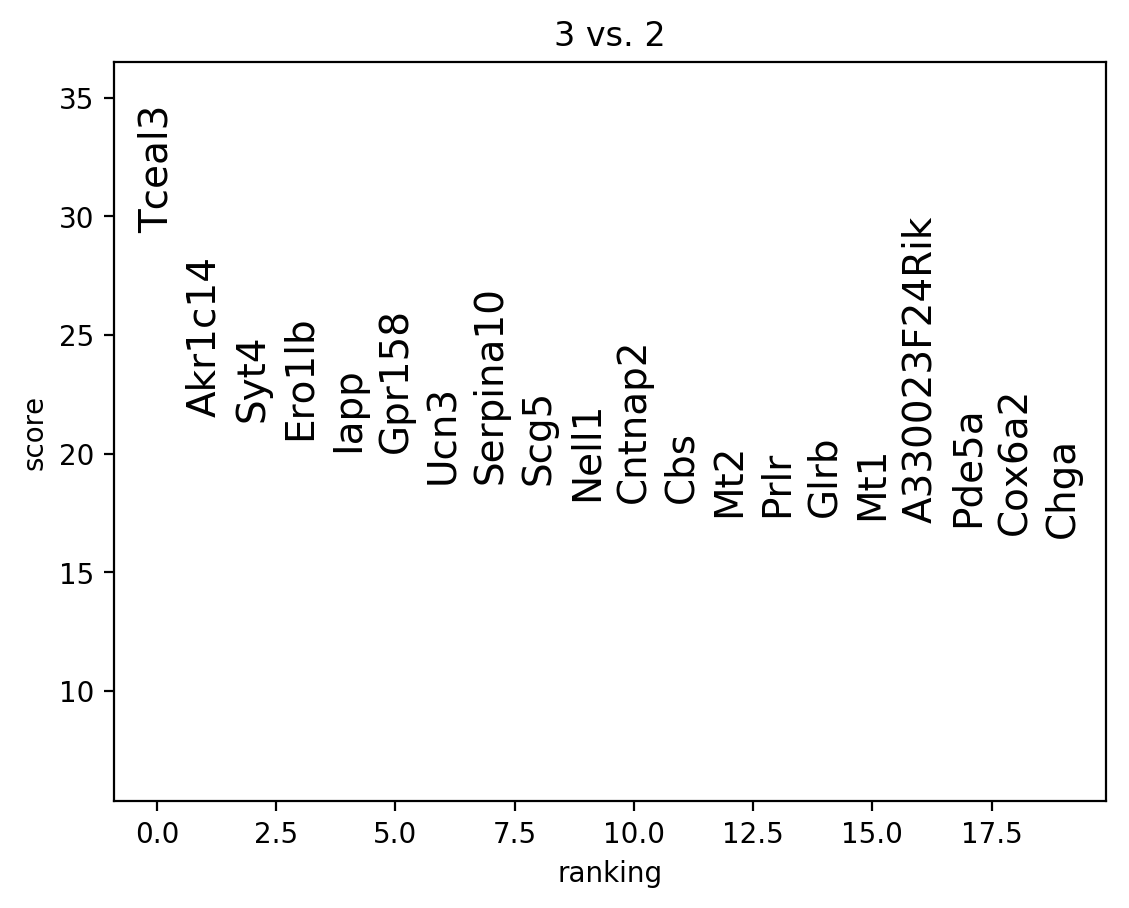

In [262]:
gr=['2']
ref='3'
key='rank_genes_'+gr[0]+'_vs_'+ref
sc.tl.rank_genes_groups(adata_beta_norm,groupby='louvain',groups=gr,reference=ref,key_added=key,n_genes=500,use_raw=False)
sc.pl.rank_genes_groups(adata_beta_norm,key=key,fontsize=14)

gr=['3']
ref='2'
key='rank_genes_'+gr[0]+'_vs_'+ref
sc.tl.rank_genes_groups(adata_beta_norm,groupby='louvain',groups=gr,reference=ref,key_added=key,n_genes=500,use_raw=False)
sc.pl.rank_genes_groups(adata_beta_norm,key=key,fontsize=14)




In [264]:
# Differential expression lists 
writer = pd.ExcelWriter('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/qiu_deg_paper.xlsx', engine='xlsxwriter')
lfc_tr=0.25


gr=['3']
ref='2'
key='rank_genes_'+gr[0]+'_vs_'+ref

names = adata_beta_norm.uns[key]['names'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
scores = adata_beta_norm.uns[key]['scores'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
lfc = adata_beta_norm.uns[key]['logfoldchanges'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
p = adata_beta_norm.uns[key]['pvals'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
p_adj = adata_beta_norm.uns[key]['pvals_adj'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
pd.DataFrame({'Names':names, 'Scores':scores,'log foldchange':lfc,'p-value':p,'adjusted p-value':p_adj}).to_excel(writer,sheet_name='P60_vs_E17.5')




gr=['2']
ref='3'
key='rank_genes_'+gr[0]+'_vs_'+ref

names = adata_beta_norm.uns[key]['names'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
scores = adata_beta_norm.uns[key]['scores'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
lfc = adata_beta_norm.uns[key]['logfoldchanges'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
p = adata_beta_norm.uns[key]['pvals'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
p_adj = adata_beta_norm.uns[key]['pvals_adj'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc_tr),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]
pd.DataFrame({'Names':names, 'Scores':scores,'log foldchange':lfc,'p-value':p,'adjusted p-value':p_adj}).to_excel(writer,sheet_name='E17.5_vs_P60')


writer.save()

In [270]:
### gene sets for scoring

lfc=0.25
gr=['2']
ref='3'
key='rank_genes_'+gr[0]+'_vs_'+ref
genes_emb_up=adata_beta_norm.uns[key]['names'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]

gr=['3']
ref='2'
key='rank_genes_'+gr[0]+'_vs_'+ref
genes_emb_down=adata_beta_norm.uns[key]['names'][gr[0]][[all([a,b]) for a,b in zip(
    (adata_beta_norm.uns[key]['logfoldchanges'][gr[0]]>lfc),(adata_beta_norm.uns[key]['pvals_adj'][gr[0]]<0.01))]]


## Compute cell scores

In [263]:
adata_stz_beta_sub=adata_stz_beta[np.isin(adata_stz_beta.obs['treatment'],['Ctrl','Vehicle-STZ'])].copy()

In [271]:
sc.tl.score_genes(adata_stz_beta_sub,gene_list=genes_emb_up,score_name='embryonic/neonatal')


computing score 'embryonic/neonatal'
    finished: added
    'embryonic/neonatal', score of gene set (adata.obs) (0:00:01)


In [272]:
sc.tl.score_genes(adata_stz_beta_sub,gene_list=genes_emb_down,score_name='maturity')


computing score 'maturity'
    finished: added
    'maturity', score of gene set (adata.obs) (0:00:01)


/Users/sophie/miniconda3/envs/scanpy_latest/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


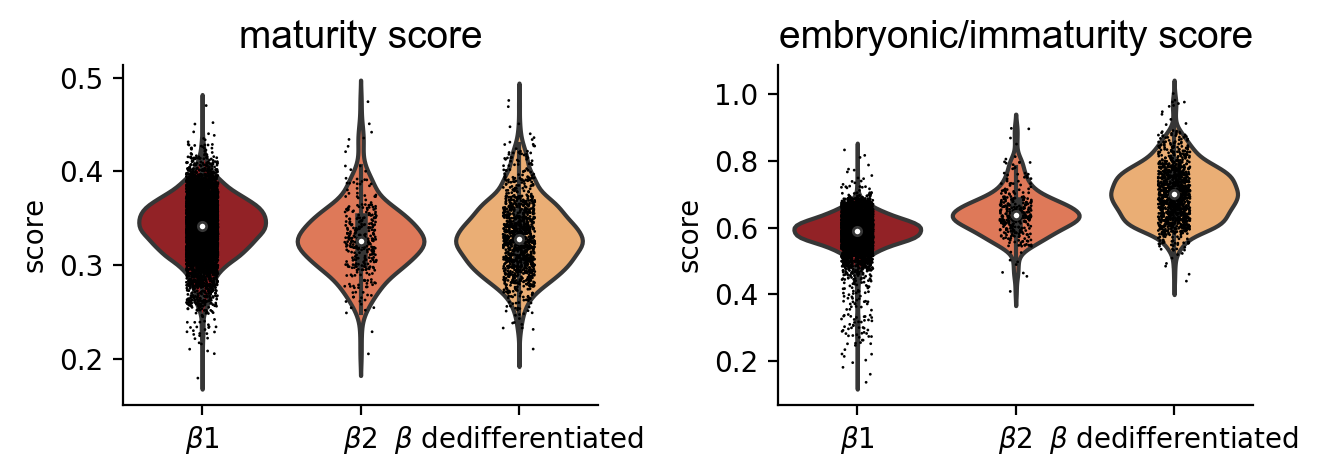

In [273]:
cols_treat=adata_stz_beta.uns['groups_named_fine_colors']
genes=['maturity','embryonic/neonatal']

gene_name=['maturity score','embryonic/immaturity score']


csfont = {'fontname':'Arial'}

import seaborn as sns
rcParams['figure.figsize'] = (6.7, 2.5)
fig,axs=pl.subplots(ncols=len(genes))
adata=adata_stz_beta_sub.copy()
for i,gene in enumerate(genes):
        

        obs_df = adata.obs
        #X_col = pd.DataFrame({gene:np.array(adata[:, gene].X)},index=obs_df.index)

        #obs_df = pd.concat([obs_df, X_col],axis=1)


        sns.stripplot(x='groups_named_fine', y=gene, data=obs_df, ax=axs[i],jitter=1,color='black',size=1)
        #obs_df[gene] = X_col
        sns.violinplot(x='groups_named_fine', y=gene, data=obs_df, scale='width',ax=axs[i],palette=cols_treat,inner='box',linewidth=1.5)
        #ax.legend_.remove()
        
        axs[i].set_xticklabels([r'$\beta$1',r'$\beta$2',r'$\beta$ dedifferentiated'],fontsize=10,rotation=0)
        axs[i].xaxis.set_tick_params(bottom='on', top='off')
        axs[i].yaxis.set_tick_params(left='on', right='off')    

        #axs[i].set_xticks([])
        #axs[i].get_yaxis().set_ticks([])
        axs[i].set_xlabel('')
        axs[i].set_ylabel('score')
        axs[i].set_title(gene_name[i],size=14,**csfont)
        axs[i].xaxis.set_tick_params(bottom='on', top='off')
        axs[i].yaxis.set_tick_params(left='on', right='off')    
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(True)
        axs[i].spines['left'].set_visible(True)
        
pl.gcf().subplots_adjust(bottom=0.2)
pl.tight_layout()
pl.savefig('/Users/sophie/Documents/ICB/Projects/2018_10X_Glp_Est_Mice/Revision/maturation_scores_final.pdf',format='pdf',dpi=300)
pl.show()
pl.rcParams.update(pl.rcParamsDefault)
   
